In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json

from matplotlib import pyplot as plt
from papermage import Document, Span, Box, Entity
from papermage.visualizers.visualizer import plot_entities_on_page

from papermage_components.table_transformer_structure_predictor import TableTransformerStructurePredictor, TatrPrediction
from papermage_components.matIE_predictor import MatIEPredictor
from papermage_components.utils import get_table_image, globalize_box_coordinates, visualize_table_with_boxes

In [3]:
json_filename = "data/processed_papers/On the creep performance of the Ti‐6Al‐4V alloy processed by additive manufacturing.json"

with open(json_filename) as f:
  parsed_paper = Document.from_json(json.load(f))

In [4]:
parsed_paper

Document with 28 layers: ['symbols', 'images', 'metadata', 'tokens', 'rows', 'pages', 'reading_order_sections', 'words', 'sentences', 'blocks', 'vila_entities', 'titles', 'paragraphs', 'authors', 'abstracts', 'keywords', 'sections', 'lists', 'bibliographies', 'equations', 'algorithms', 'figures', 'tables', 'captions', 'headers', 'footers', 'footnotes', 'TAGGED_IMAGE_Table_Transformer']

In [5]:
tsp = TableTransformerStructurePredictor.from_model_name()

/Users/sireeshgururaja/miniconda3/envs/papermage/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
tables = tsp.predict(parsed_paper)

  0%|          | 0/8 [00:00<?, ?it/s]

In [7]:
tables[0].metadata.keys()

dict_keys(['raw_prediction', 'predicted_dict', 'predicted_boxes', 'predicted_caption'])

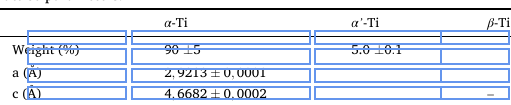

In [8]:
scale_factor = 1.0
boxes = [[b[0]/scale_factor, b[1]/scale_factor, b[2]/scale_factor, b[3]/scale_factor, b[4]] for b in tables[0].metadata["predicted_boxes"]]
visualize_table_with_boxes(tables[0], boxes, parsed_paper, False)


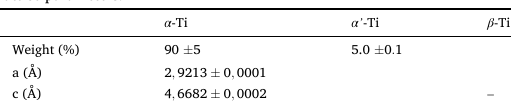

In [91]:
from PIL import Image
img = Image.open("data/img.png").convert("RGB")
img

img = get_table_image(tables[0], parsed_paper)
img

In [92]:
from papermage_components.table_transformer_structure_predictor import *

In [110]:
pixel_values = structure_transform(img).unsqueeze(0)
with torch.no_grad():
    outputs = tsp.model(pixel_values)
structure_id2label = tsp.model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"
predictions = format_model_output(outputs, structure_id2label, img.size)
header_column_mapping = get_header_column_cell_mapping(predictions)

In [115]:
globalize_box_coordinates(predictions[0].bbox, tables[0].boxes[0], parsed_paper)

Box[0.6207017268469, 0.11837282781856055, 0.1471481184090125, 0.043908981335024154, 2]

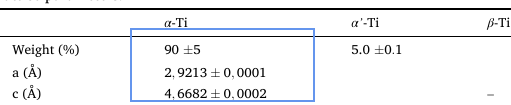

In [118]:
visualize_table_with_boxes(tables[0], [globalize_box_coordinates(p.bbox, tables[0].boxes[0], parsed_paper).to_json() for p in predictions][:1], parsed_paper, False)

In [112]:
predictions[0]

TatrPrediction(label='table column', score=0.9999663829803467, bbox=Box[0.23791079223155975, 0.13491415977478027, 0.3663622736930847, 0.8255661129951477, -1])

In [103]:
predictions[0]

TatrPrediction(label='table column', score=0.9999663829803467, bbox=Box[121.57241821289062, 14.165987014770508, 308.7835388183594, 100.85042572021484, -1])

In [104]:
img.size

(511, 105)

In [109]:
predictions[0].bbox.l/511, 308/511

(0.23791079885105798, 0.6027397260273972)

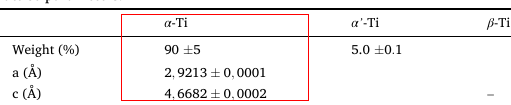

In [96]:
from PIL import ImageDraw

cropped_table_visualized = img.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for prediction in predictions[:1]:
  draw.rectangle(prediction.bbox.to_json()[:4], outline="red")

cropped_table_visualized